<a href="https://colab.research.google.com/github/ai-fast-track/icedata/blob/master/notebooks/dev/indoor_objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Warning
This notebook is a work in progress document. We are sharing it with the IceVision Community through our Live Code Session (beginners-friendly). If you are interested in attending, please feel free to [join us](http://tinyurl.com/IceData)

## About the Indoor Objects Dataset
This indoor dataset consists of 2213 image frames containing seven classes. The dataset includes a variety of background, lighting conditions, occlusion and high inter-class differences.

- Dataset [Repository](https://zenodo.org/record/2654485#.X4EG72hKhPZ)

- Dataset [zip file](https://zenodo.org/record/2654485/files/Indoor%20Object%20Detection%20Dataset.zip)

- Paper: [Faster Bounding Box Annotation for Object Detection in Indoor Scenes](https://ieeexplore.ieee.org/document/8611732)

- License (for files): [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/legalcode)


# A Parser Example: Creating a new parser for a custom XML annotation file
> **Goal**: This notebook shows how to create a new parser for a custom XML annotation file. The XML file contains all images annotation in one single file. In a sense, it is similar to the COCO annotation format where all the image annotation are stored in the same JSON file as opposed to VOC annotation where each file has its XML annotation file.



## Installing IceVision

!!! warning "Google Colab Dependencies Incompatibilities "
    This issue is specific to Google Colab. The issue shouldn't occur on a local machine.
    Some of our external dependencies are not aligned with the dependencies pre-installed in Google Colab. 
    After pip installing both icevision and icedata (by runnning the cell here below), some errors will eventually pop up.
    To fix this issue, press the **RESTART RUNTIME** button.

In [ ]:
# Installing from PyPi
!pip install icevision[all] icedata

# This a Colab issue, and here we are forcing the "Restart Runtime" programatically
import os
os.kill(os.getpid(), 9)

In [2]:
# Instaling from GitHub master
# !pip install git+git://github.com/icevision/icevision.git#egg=icevision[all] --upgrade

## Imports

In [1]:
from icevision.all import *

## Downloading the dataset
In this example, we use the **icedata** `load_data()` method to download the dataset.

In [2]:
# !git clone https://github.com/ai-fast-track/dataset.git
# Loading Data
url = "https://zenodo.org/record/2654485/files/Indoor%20Object%20Detection%20Dataset.zip"
dest_dir = "."
data_dir = icedata.load_data(url, dest_dir, force_download=True)

In [3]:
data_dir.ls()

(#2) [Path('/root/.icevision/data/Indoor%20Object%20Detection%20Dataset.zip'),Path('/root/.icevision/data/Indoor Object Detection Dataset')]

In [4]:
!ls /root/.icevision/data/'Indoor Object Detection Dataset'

annotation  sequence_1	sequence_3  sequence_5
info.txt    sequence_2	sequence_4  sequence_6


In [5]:
# renaming the problematic folder name and move it to the current directory
!mv  ~/.icevision/data/'Indoor Object Detection Dataset' indoor_objects
!ls

indoor_objects	sample_data


In [6]:
!ls indoor_objects

annotation  sequence_1	sequence_3  sequence_5
info.txt    sequence_2	sequence_4  sequence_6


### Set images and annotations directories

In [7]:
data_dir = Path('./indoor_objects')	
data_dir.ls()

(#8) [Path('indoor_objects/sequence_2'),Path('indoor_objects/info.txt'),Path('indoor_objects/sequence_1'),Path('indoor_objects/sequence_6'),Path('indoor_objects/sequence_5'),Path('indoor_objects/sequence_4'),Path('indoor_objects/annotation'),Path('indoor_objects/sequence_3')]

In [8]:
images_dir = data_dir / "sequence_1"		
annotations_dir = data_dir / "annotation"
annotations_file = annotations_dir / 'annotation_s1.xml'
annotations_file

Path('indoor_objects/annotation/annotation_s1.xml')

In [9]:
images_dir.ls()

(#148) [Path('indoor_objects/sequence_1/frame_s1_8.jpg'),Path('indoor_objects/sequence_1/frame_s1_6.jpg'),Path('indoor_objects/sequence_1/frame_s1_29.jpg'),Path('indoor_objects/sequence_1/frame_s1_24.jpg'),Path('indoor_objects/sequence_1/frame_s1_37.jpg'),Path('indoor_objects/sequence_1/frame_s1_137.jpg'),Path('indoor_objects/sequence_1/frame_s1_27.jpg'),Path('indoor_objects/sequence_1/frame_s1_118.jpg'),Path('indoor_objects/sequence_1/frame_s1_55.jpg'),Path('indoor_objects/sequence_1/frame_s1_71.jpg')...]

In [10]:
# print the annotations file
!cat indoor_objects/annotation/annotation_s1.xml

<?xml version='1.0' encoding='ISO-8859-1'?>
<?xml-stylesheet type='text/xsl' href='image_metadata_stylesheet.xsl'?>
<dataset>
<name> TUT Indoor Object Detection Dataset</name>
<comment>Created on 03-06-2018 by Bishwo Adhikari</comment>
<images>
  <image file='frame_s1_1.jpg'>
    <box top='244' left='500' width='192' height='99'>
      <label>exit</label>
    </box>
    <box top='358' left='742' width='218' height='105'>
      <label>exit</label>
    </box>
  </image>
  <image file='frame_s1_10.jpg'>
    <box top='97' left='651' width='79' height='81'>
      <label>fireextinguisher</label>
    </box>
    <box top='354' left='667' width='109' height='281'>
      <label>fireextinguisher</label>
    </box>
  </image>
  <image file='frame_s1_100.jpg'>
    <box top='159' left='460' width='172' height='169'>
      <label>clock</label>
    </box>
  </image>
  <image file='frame_s1_101.jpg'>
    <box top='114' left='577' width='238' height='303'>
      <label>chair</label>
    </box>
    <box 

In [11]:
# !cat ~/.icevision/data/indoor_object/"Indoor Object Detection Dataset"/info.txt

### Define class_map

In [12]:
classes = """
chair
screen
exit
fireextinguisher
printer
clock
trashbin
"""
classes

'\nchair\nscreen\nexit\nfireextinguisher\nprinter\nclock\ntrashbin\n'

In [13]:
_CLASSES = classes.strip('\n').split('\n')
_CLASSES

['chair', 'screen', 'exit', 'fireextinguisher', 'printer', 'clock', 'trashbin']

In [14]:
class_map = ClassMap(_CLASSES)

In [15]:
class_map.get_name('fireextinguisher')

4

## Parser: Creating a new parser from scratch

### Note
The Indoor Objects Dataset uses a custom XML annotation format. Therefore, we need to create a brand new parser.

In [16]:
import xml.etree.ElementTree as ET

In [17]:
annotations_file

Path('indoor_objects/annotation/annotation_s1.xml')

In [18]:
tree = ET.parse(str(annotations_file))
_root = tree.getroot()
object = _root.findall('images/image')

In [ ]:
for item in object:
  # print(item.get('file'))
  for bbox_tag in item.findall('box'):
    print(bbox_tag.get('top'))
    print(bbox_tag.find('label').text)
    

In [20]:
labels = set()
for bbox_tag in _root.findall('images/image/box'):
  label = bbox_tag.find("label").text
  labels.add(label)

labels = list(labels)
labels

['exit', 'chair', 'fireextinguisher', 'trashbin', 'clock']

In [21]:
labels = set()
for img_tag in _root.findall('images/image'):
  for bbox_tag in img_tag.findall('box'):
    label = bbox_tag.find("label").text
    labels.add(label)

labels = list(labels)
labels

['exit', 'chair', 'fireextinguisher', 'trashbin', 'clock']

In [ ]:
# for item in _root.findall('images/image'):
#   print(item.get('file'))

In [28]:
# Indoor uses several Parser Mixins
class IndoorParser(parsers.Parser, parsers.ImageidMixin, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin): 
    def __init__(
        self,
        annotations_file: Union[str, Path],
        images_dir: Union[str, Path],
        class_map: ClassMap,
    ):
        self.images_dir = Path(images_dir)
        self.class_map = class_map

        self.annotations_file = annotations_file
        # self.annotation_files = get_files(self.annotations_dir, extensions=[".xml"])

        tree = ET.parse(str(annotations_file))
        self._root = tree.getroot()

    def __len__(self):
        return len(self.annotation_files)

    def __iter__(self):
        yield from self._root.findall('images/image')
    
    # Use prepare to avoid code duplication in different methods (e.g. bboxes(), labels(), etc.)
    def prepare(self, o):
        def to_int(x):
            return int(float(x))
        
        self._filename = o.get('file')

        fname = self.images_dir / self._filename
        img = open_img(fname)
        img_h, img_w, _ = img.shape

        bboxes = []
        labels = []
        for bbox_tag in o.findall('box'):
            xmin = to_int(bbox_tag.get("left"))
            ymin = to_int(bbox_tag.get("top"))
            width = to_int(bbox_tag.get("width"))
            height = to_int(bbox_tag.get("height"))
            xmax = xmin+width
            ymax = ymin+height
            
            # xmin = max(xmin, 0)
            # ymin = max(ymin, 0)
            # xmax = min(xmin+width, img_w)
            # ymax = min(ymin+height, img_h) 

            bbox = BBox.from_xyxy(xmin, ymin, xmax, ymax)
            bboxes.append(bbox)

            label = bbox_tag.find("label").text
            label = class_map.get_name(label)
            labels.append(label)

        self._bboxes =  bboxes 
        self._labels = labels

    
    def filepath(self, o) -> Union[str, Path]:
        return self.images_dir / self._filename  
    
    def imageid(self, o) -> Hashable:
        return Path(self._filename).stem

    def labels(self, o) -> List[int]:
        return self._labels

    def bboxes(self, o) -> List[BBox]:
        return self._bboxes        

In [29]:
parser = IndoorParser(annotations_file=annotations_file, images_dir=images_dir, class_map=class_map)

In [49]:
train_records, valid_records = parser.parse()

In [50]:
train_records[0]

{'bboxes': [BBox(pnts=[499, 301, 691, 400])],
 'filepath': Path('indoor_objects/sequence_1/frame_s1_128.jpg'),
 'imageid': 32,
 'labels': [3]}

In [ ]:
<image file='frame_s1_128.jpg'>
    <box top='301' left='499' width='192' height='99'>
      <label>exit</label>
    </box>
</image>

### Using `sequence_3` as a training dataset and `sequence_6` as a validation dataset

In [34]:
parser_train = IndoorParser(annotations_file=annotations_dir / 'annotation_s3.xml', images_dir=data_dir / "sequence_3", class_map=class_map)
parser_valid = IndoorParser(annotations_file=annotations_dir / 'annotation_s6.xml', images_dir=data_dir / "sequence_6", class_map=class_map)

### train and validation records

In [35]:
data_splitter=SingleSplitSplitter()
data_splitter

In [46]:
# train_records = parser_train.parse(data_splitter=RandomSplitter([.99, .01]))[0]
train_records = parser_train.parse(data_splitter=data_splitter)[0]

In [44]:
# valid_records = parser_valid.parse(data_splitter=RandomSplitter([.99, .01]))[0]
valid_records = parser_valid.parse(data_splitter=data_splitter)[0]

In [51]:
valid_records[0]

{'bboxes': [BBox(pnts=[651, 122, 726, 195]), BBox(pnts=[672, 399, 747, 614])],
 'filepath': Path('indoor_objects/sequence_1/frame_s1_12.jpg'),
 'imageid': 23,
 'labels': [4, 4]}

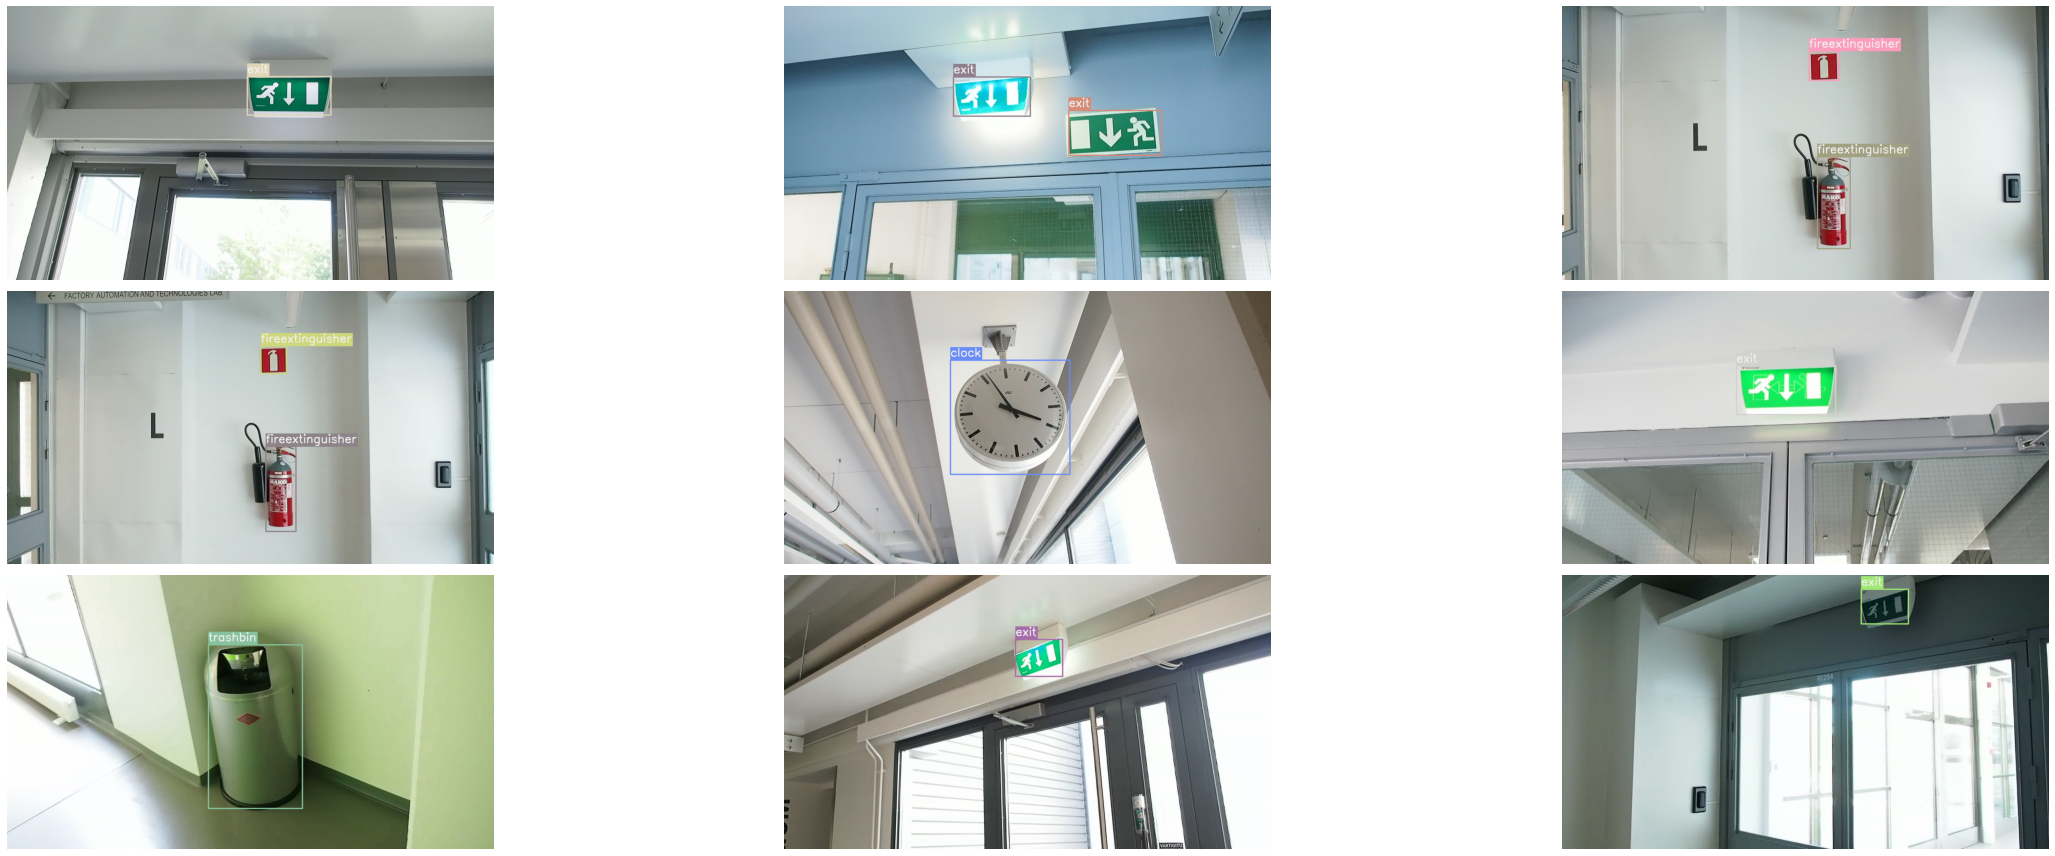

In [53]:
show_records(train_records[9:18], ncols=3, class_map=class_map)

## Datasets
### Transforms

In [54]:
presize = 512
size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

### Train and Validation Dataset Objects

In [55]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Picking one **single sample** from the training dataset and checking transforms

> **Note**: Some random transforms are applied every time we run the code here below. The applied transforms  are those defined in the [aug_tfms](https://github.com/airctic/icevision/blob/master/icevision/tfms/albumentations/tfms.py)

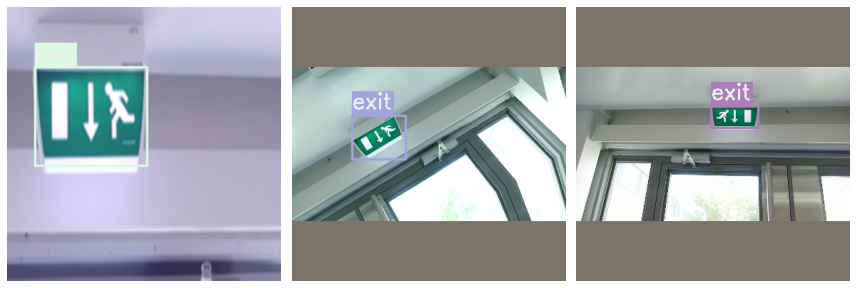

In [59]:
samples = [train_ds[9] for _ in range(3)]
show_samples(samples, class_map=class_map, denormalize_fn=denormalize_imagenet, ncols=3)

### Picking one **single sample** from the validattion dataset and checking transforms

> **Note**: No random transform is applied. Only `resize_and_pad()` and  `Normalize()` are applied

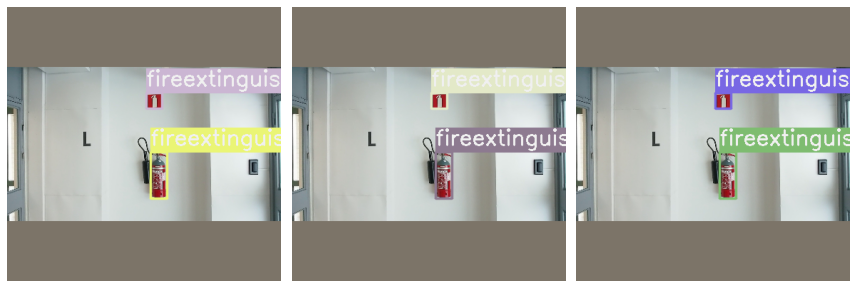

In [58]:
samples = [valid_ds[0
] for _ in range(3)]
show_samples(samples, class_map=class_map, denormalize_fn=denormalize_imagenet, ncols=3)

### DataLoaders

In [120]:
model_type = efficientdet # faster_rcnn # efficientdet 

In [121]:
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

### Model

In [122]:
# model = model_type.model(num_classes=len(class_map))
model = model_type.model('tf_efficientdet_lite0', num_classes=len(class_map), img_size=size)

### Fastai Learner

In [123]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [124]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

## Fastai Training
### Learning Rate Finder

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

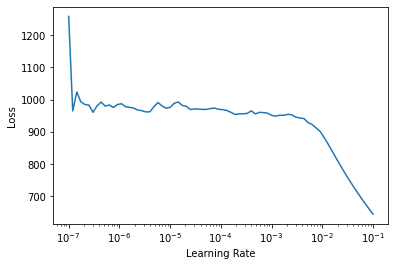

In [126]:
# learn.freeze()
# learn.lr_find()

### Fine tune: 2 Phases
- Phase 1: Train the head for 3 epochs while freezing the body
- Phase 2: Train both the body and the head during 50 epochs

In [128]:
from fastai.callback.tracker import SaveModelCallback
fname='indoor-object-efficientdet-best'
learn.fine_tune(10, 0.012, freeze_epochs=3, cbs=SaveModelCallback(monitor='COCOMetric', fname=fname))

epoch,train_loss,valid_loss,COCOMetric,time
0,0.212237,0.351517,0.455945,00:33
1,0.226219,0.404208,0.432191,00:33
2,0.246760,0.507146,0.383954,00:32


Better model found at epoch 0 with COCOMetric value: 0.45594539429251196.


epoch,train_loss,valid_loss,COCOMetric,time
0,0.222068,0.363865,0.450967,00:34
1,0.235417,0.406025,0.428272,00:34
2,0.248629,0.420364,0.431178,00:34
3,0.253463,0.427388,0.393729,00:34
4,0.242151,0.393742,0.404780,00:34
5,0.236937,0.383818,0.429947,00:34
6,0.221808,0.362628,0.461580,00:34
7,0.202884,0.375585,0.471734,00:34
8,0.198337,0.362089,0.460416,00:34
9,0.191392,0.361926,0.470686,00:34


Better model found at epoch 0 with COCOMetric value: 0.45096737767407064.
Better model found at epoch 6 with COCOMetric value: 0.46157993606936143.
Better model found at epoch 7 with COCOMetric value: 0.4717343876300422.


## Saving a Model on Google Drive

>Note: In this example, we suppose you have already created a folder called **models** in your Google Drive

In [ ]:
## Mount your Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

Mounted at /content/gdrive


### Saving the last model

In [ ]:
torch.save(model.state_dict(), root_dir/'indoor-object-efficientdet.pth')

### Saving the best model

In [ ]:
!ls models

bccd-faster-rcnn-best.pth


In [ ]:
!cp models/bccd-faster-rcnn-best.pth /content/gdrive/"My Drive"/models/indoor-object-efficientdet-best.pth

## Show results

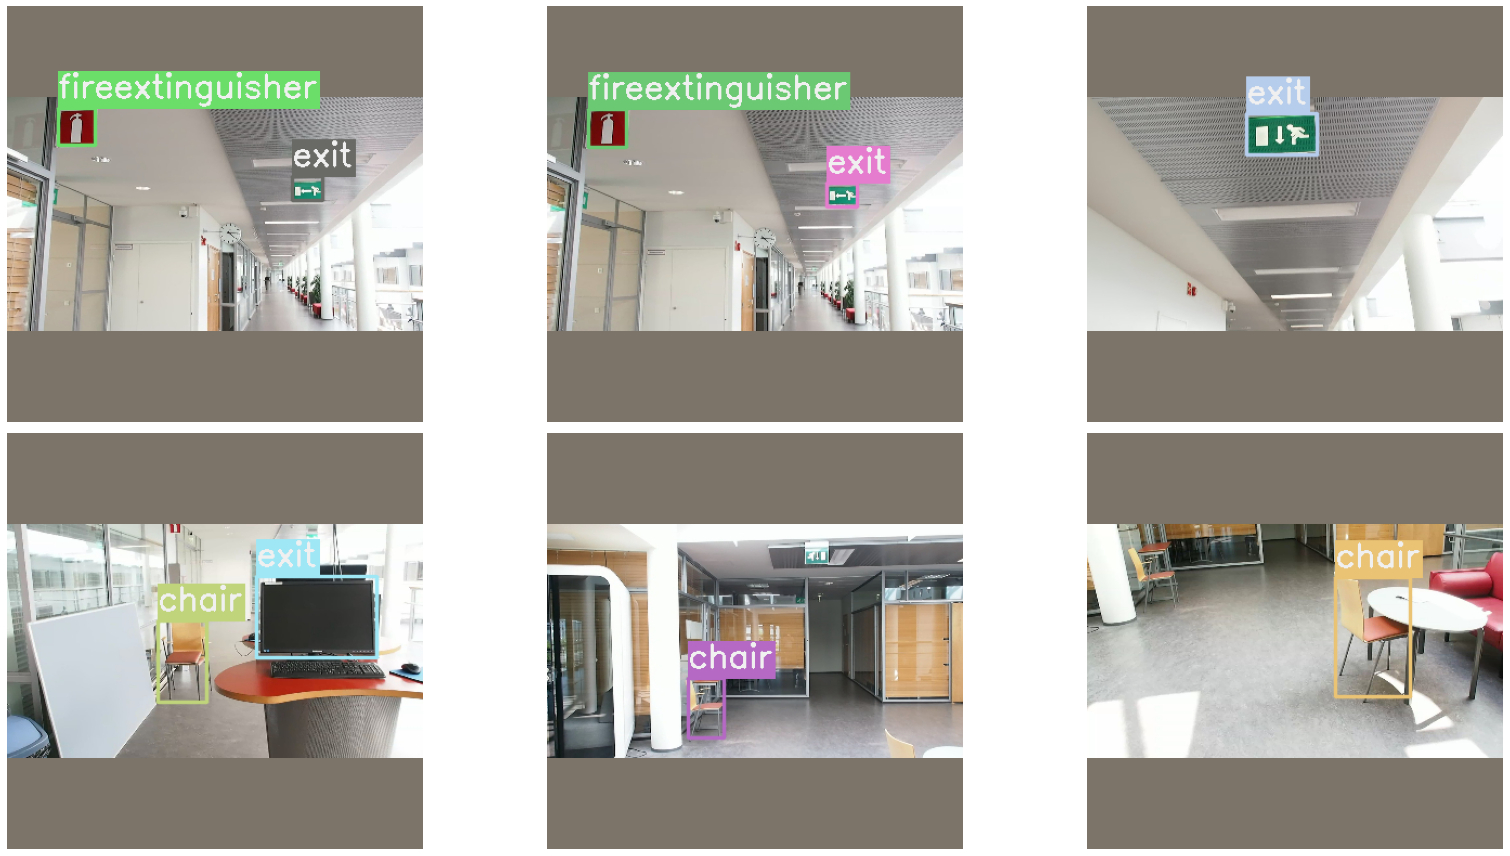

In [127]:
model_type.show_results(model, valid_ds, class_map=class_map)

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).